It was reported that the results from using the old cwfs code https://github.com/lsst-ts/ts_externalscripts/blob/develop/python/lsst/ts/externalscripts/auxtel/latiss_cwfs_align.py
vs ts_wep implementation https://github.com/lsst-ts/ts_externalscripts/blob/develop/python/lsst/ts/externalscripts/auxtel/latiss_wep_align.py for auxtel are incompatible beyond an acceptable threshold using the test data https://github.com/lsst-ts/ts_externalscripts/blob/develop/tests/auxtel/test_latiss_cwfs_align.py . There could be an issue with a wrong value for the central obscuration, or other reason for the discrepancy. This ticket is to look into it and address necessary updates in ts_wep code for auxtel if needed.

# `latiss_cwfs_align` 

Is the baseline which  uses Bo's old cwfs code. 

Two routines to first get the intra/extra exposures given the `intra_visit_id` and `extra_visit_id` : `lsst.ts.observing.utilities.auxtel.latiss.getters.get_image`. The `lsst.ts.observing.utilities.auxtel.latiss.utils.parse_visit_id` simply takes the `visit_id`, eg. `2021032300308`, and creates from it a  
```data_id = {
        "day_obs": day_obs,
        "seq_num": seq_num,
        "detector": 0,
        "instrument": "LATISS",
    }
```
dictionary. The `get_image`  uses `best_effort_isr.getExposure(data_id)`, and waits in case there are any stability butler issues.  Both modules are from https://github.com/lsst-ts/ts_observing_utilities/tree/develop/python/lsst/ts/observing/utilities/auxtel/latiss 


The `best_effort_isr` is an instance of the `BestEffortIsr` class https://github.com/lsst-sitcom/summit_utils/blob/main/python/lsst/summit/utils/bestEffort.py  it : 

    returns an assembled image with as much
    isr performed as possible, dictated by the calibration products available,
    and optionally interpolates over cosmic rays. If an image image already
    exists in the butler, it is returned (for the sake of speed), otherwise it
    is generated and put(). Calibration products are loaded and cached to
    improve performance.
    
(according to `BestEffortIsr` docstring). Uses the following ISR settings:

       isrConfig = IsrTask.ConfigClass()
        isrConfig.doWrite = False  # this task writes separately, no need for this
        isrConfig.doSaturation = True  # saturation very important for roundness measurement in qfm
        isrConfig.doSaturationInterpolation = True
        isrConfig.overscan.leadingColumnsToSkip = 5
        isrConfig.overscan.fitType = 'MEDIAN_PER_ROW'
        
        
Once it has the ISR image, it runs source detection using `functools.partial` https://docs.python.org/3/library/functools.html  to parse `exposure` and `donutDiameter` as parameters to `QuickFrameMeasurementTask`  https://github.com/lsst/pipe_tasks/blob/main/python/lsst/pipe/tasks/quickFrameMeasurement.py  . This is a quick source detection task that can be used to detect donuts (**why aren't we using that?** ). 


Then it cuts out stamps given the detected sources location (centroid), and runs the original cwfs code with ` self.algo.runIt, self.inst, self.I1[0], self.I2[0], "paraxial"` , i.e. by default uses `paraxial` as `opticalModel`. 


The Zernikes of interest are the following:
        

        self.zern = [
            -self.algo.zer4UpNm[3],  # Coma-X (in detector axes, TBC)
            self.algo.zer4UpNm[4],  # Coma-Y (in detector axes, TBC)
            self.algo.zer4UpNm[0],  # defocus
        ]
       
       
Notice that here the indices are `[3,4,0]` . 

# `latiss_wep_align`

The `ts_wep` code is used here. 

https://github.com/lsst-ts/ts_externalscripts/blob/develop/python/lsst/ts/externalscripts/auxtel/latiss_wep_align.py

It again uses `functools.partial` to parse as arguments the to `run_wep` function. 

The sources are similarly detected with `QuickFrameMeasurementTask`  , and the wavefront estimation is done using  `EstimateZernikesLatissTask`  https://github.com/lsst-ts/ts_externalscripts/blob/8ba110cd64a134bf7d4efca424477c26deec96eb/python/lsst/ts/externalscripts/auxtel/latiss_wep_align.py#L194  **need to update to CalcZernikesTask** with appropriate config given PR159 to ts_wep .... 


The Zernikes of interest are obtained in the following fashion:
   
   
      self.zern = [
                -wep_results.outputZernikesAvg[0][4] * 1e3,
                wep_results.outputZernikesAvg[0][3] * 1e3,
                wep_results.outputZernikesAvg[0][0] * 1e3,
            ]
            
Also, it uses by default the `onAxis` optical model https://github.com/lsst-ts/ts_externalscripts/blob/8ba110cd64a134bf7d4efca424477c26deec96eb/python/lsst/ts/externalscripts/auxtel/latiss_wep_align.py#L192             
            
Notice: indices are `[4,3,0]`. **Is this a mistake or intentional?** I don't think that the output of `Algorithm` has changed in that way between the original `cwfs` code and `ts_wep` implementation?             
            

**Next:**
    
    * run with some auxTel exposures - get the direct output of `latiss_cwfs_align`  vs `latiss_wep_align`. Does switching indices and optical models change anything? 
    * look at the output of running `quickFrameMeasurementTask`  - what sources do we get ? Could we run it instead of `deblend adapt` ? Could we use that instead of our donut detection code? 
    (given that it returns footprints and centroids and other source information... )

## Run  auxTel data with these scripts ...

Try to pull the actual content of scripts to see at which point we get divergent results...

The test code https://github.com/lsst-ts/ts_externalscripts/blob/develop/tests/auxtel/test_latiss_cwfs_align.py


First the `test_take_sequence` uses


     Data was taken on 2021-11-04.
        Prior to the set, telescope was focused, then hexapod was
        offset by x=1, y=1, z=0.05 mm.
        ==============================
        Measured [coma-X, coma-Y, focus] zernike coefficients [nm]:
        [-11.1, 14.5, -9.5, ]
        De-rotated [coma-X, coma-Y, focus]  zernike coefficients [nm]:
        [-9.0, 15.9, -9.5, ]
        Hexapod [x, y, z] offsets [mm] : -0.044, -0.077, -0.004,
        Telescope offsets [arcsec]: -2.3, -3.9, 0.0,
        ==============================
        Focus (-0.004) and coma (0.089) offsets inside tolerance level (0.010).
        Total focus correction: -0.004 mm.
        Total coma-x correction: 0.000 mm. Total coma-y correction: 0.000 mm.
        Applying telescope offset [az,el]: [-3.892, -2.297].
        
        
         # output on-sky from last pair
            centroid = [2708, 3094]  # [y,x]

            meas_zerns = [-11.1, 14.5, -9.5]
            # De - rotated zernike
            rot_zerns = [-9.0, 15.9, -9.5]
            # Hexapod offsets
            hex_offsets = [-0.044, -0.077, -0.004]
            # Telescope offsets
            tel_offsets = [-2.3, -3.9, 0.0]


 
There the `test_analysis` uses  a single image pair: `954-955` 

     Data was taken on 2021-11-04, images 954-955. This is a middle
        iteration of a the set used in test_full_sequence.
        Prior to the set, telescope was focused, then hexapod was
        offset by x=1, y=1, z=0.05 mm.
        This test looks at only the analysis of images 954-955, where
        the output was:
        intraImage expId for target: 2021110400954
        extraImage expId for target: 2021110400955
        angle used in cwfs algorithm is 11.77
        Creating stamp for intra_image donut on centroid
        [y,x] = [3094,2708] with a side length of 228 pixels
        Creating stamp for intra_image donut on centroid
        [y,x] = [3090,2713] with a side length of 228 pixels
        ==============================
        Measured [coma-X, coma-Y, focus] zernike coefficients [nm]:
        [-60.1, 30.8, 50.7, ]
        De-rotated [coma-X, coma-Y, focus]  zernike coefficients [nm]:
        [-52.6, 42.4, 50.7, ]
        Hexapod [x, y, z] offsets [mm] : -0.255, -0.206, 0.007,
        Telescope offsets [arcsec]: -13.4, -10.4, 0.0,
        ==============================
        Applying offset:
        x=-0.2551161770829597, y=-0.20577598056746502, z=0.006737514919628802.
        
        
         # output on-sky from first pair
         centroid = [2708, 3094]  # [x,y]

         meas_zerns = [-60.1,30.8,50.7,]
        
         # De-rotated zernike
         rot_zerns = [ -52.6,42.4, 50.7,]
        
So  test first using a single image pair, as it's clearer what am I comparing to ... 




In [1]:
def parse_visit_id(visit_id):
    """Return a data_id dictionary from a visit ID (which is returned from
    the take_image command to the ATCamera)
    The dictionary is formatted for a gen3 butler.
    Parameters
    ----------
    visit_id: `int` or `str`
        Visit id (e.g. '2021032300308')
    Returns
    -------
    data_id: `dict`
        dictionary with newly derived day_obs and seq_num keys to be
        used with a butler
    """
    _visit_id = str(visit_id)
    day_obs = int(f"{_visit_id[0:4]}{_visit_id[4:6]}{_visit_id[6:8]}")
    seq_num = int(_visit_id[9::])

    data_id = {
        "day_obs": day_obs,
        "seq_num": seq_num,
        "detector": 0,
        "instrument": "LATISS",
    }

    return data_id


## latiss_cwfs_align


It uses https://github.com/lsst-ts/cwfs   - a fork of Bo's original code. I go in a similar order as the code is written. 

Initialize butler:

In [2]:
import lsst.daf.butler as dafButler
DATAPATH = "/sdf/data/rubin/repo/main"  # Same value for SUMMIT and test stands

butler = dafButler.Butler(
    DATAPATH,
    instrument="LATISS",
    collections=["LATISS/raw/all", "LATISS_test_data"],
)

Initialize donut measurement class:

In [3]:
from lsst.pipe.tasks.quickFrameMeasurement import QuickFrameMeasurementTask
qm_config = QuickFrameMeasurementTask.ConfigClass()
qm = QuickFrameMeasurementTask(config=qm_config)

INFO:numexpr.utils:Note: detected 128 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
INFO:numexpr.utils:Note: NumExpr detected 128 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Now I don't have access to `bestEffortIsr`. Also, it uses the summit butler, which I can't access. But I can try replicate what it does, so that I can use 

  
    self.intra_exposure, self.extra_exposure = await asyncio.gather(
            get_image(
                parse_visit_id(self.intra_visit_id),
                self.best_effort_isr,
                timeout=self.timeout_get_image,
            ),
            get_image(
                parse_visit_id(self.extra_visit_id),
                self.best_effort_isr,
                timeout=self.timeout_get_image,
            ),
        )

    

In [4]:
# from lsst.ts.observing.utilities.auxtel.latiss.utils import parse_visit_id
def parse_visit_id(visit_id):
    """Return a data_id dictionary from a visit ID (which is returned from
    the take_image command to the ATCamera)
    The dictionary is formatted for a gen3 butler.
    Parameters
    ----------
    visit_id: `int` or `str`
        Visit id (e.g. '2021032300308')
    Returns
    -------
    data_id: `dict`
        dictionary with newly derived day_obs and seq_num keys to be
        used with a butler
    """
    _visit_id = str(visit_id)
    day_obs = int(f"{_visit_id[0:4]}{_visit_id[4:6]}{_visit_id[6:8]}")
    seq_num = int(_visit_id[9::])

    data_id = {
        "day_obs": day_obs,
        "seq_num": seq_num,
        "detector": 0,
        "instrument": "LATISS",
    }

    return data_id


In [5]:
intra_visit_id = 2021110400954
extra_visit_id = 2021110400955
intra_data_id = parse_visit_id(intra_visit_id)
extra_data_id = parse_visit_id(extra_visit_id)

In [10]:
intra_data_id

{'day_obs': 20211104, 'seq_num': 954, 'detector': 0, 'instrument': 'LATISS'}

Now need to pull these exposures from the butler and run the ISR... Use the settings like from `bestEffortIsr` :    

        isrConfig.doWrite = False  # this task writes separately, no need for this
        isrConfig.doSaturation = True  # saturation very important for roundness measurement in qfm
        isrConfig.doSaturationInterpolation = True
        isrConfig.overscan.leadingColumnsToSkip = 5
        isrConfig.overscan.fitType = 'MEDIAN_PER_ROW'
        
So I write in `testLatiss.yaml` the following : 


    description: ISR basic processing pipeline
    instrument: lsst.obs.lsst.Latiss
    tasks:
      isr:
        class: lsst.ip.isr.isrTask.IsrTask
        config:
          connections.outputExposure: postISRCCD
          doApplyGains: false
          doBias: true
          doBrighterFatter: false
          doCrosstalk: false
          doDark: true
          doDefect: false
          doFlat: true
          doFringe: true
          doInterpolate: true
          doLinearize: false
          doSaturation: true
          doSaturationInterpolation: true
          doNanMasking: false
          doOverscan: true
          doVariance: false
   
          python: OverscanCorrectionTask.ConfigClass.fitType = 'MEDIAN_PER_ROW'
          python: OverscanCorrectionTask.ConfigClass.leadingColumnsToSkip = 5
          
This doesn't work... How can I pass multiple python settings?  

What seems to work is the old 
     
          overscan.fitType : 'MEDIAN_PER_ROW'
          overscan.leadingColumnsToSkip : 5
             
             
that I saved into `testLatiss1.yaml`. 

    pipetask run  --data-query "exposure IN (2021110400954,2021110400955) AND instrument='LATISS' " -b /sdf/data/rubin/repo/main/butler.yaml --input  LATISS/raw/all,LATISS/calib,u/czw/DM-28920/calib.20210720  --output u/scichris/Latiss/testCwfs --pipeline /sdf/home/s/scichris/link_to_scichris/WORK/AOS/DM-37396/testLatiss.yaml  --register-dataset-types

Look at the resulting postISR exposure: 

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.visualization import ZScaleInterval
zscale = ZScaleInterval()

from lsst.daf import butler as dafButler
instrument = 'LATISS'
dataId0 = dict(instrument=instrument)
repo_dir = '/sdf/data/rubin/repo/main/'
butler = dafButler.Butler(repo_dir, collections=['run1'])
                      
collection = 'u/scichris/Latiss/testCwfs'
dataset = next(iter(
                butler.registry.queryDatasets(
                    datasetType='postISRCCD', 
                    collections=[collection],
                    dataId=dataId0  )
                )
           )

expN = dataset.dataId["exposure"]

Text(0.5, 1.0, 'extra')

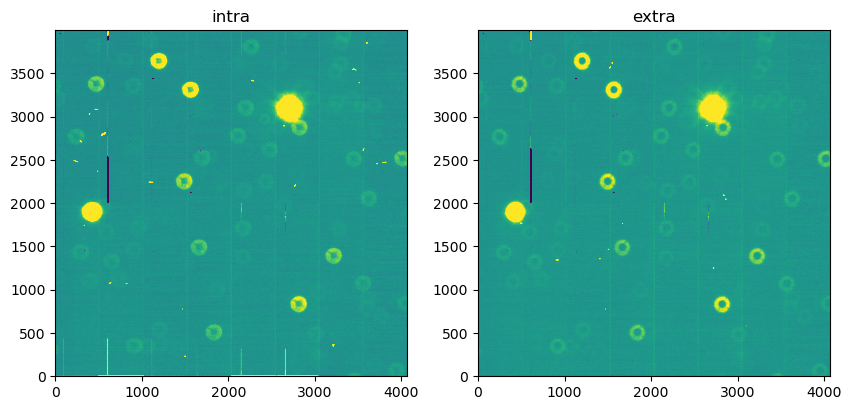

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.visualization import ZScaleInterval
zscale = ZScaleInterval()

from lsst.daf import butler as dafButler

    
    
intra_exposure = butler.get(datasetRefOrType='postISRCCD',dataId=intra_data_id,
              collections=[collection])

extra_exposure = butler.get(datasetRefOrType='postISRCCD',dataId=extra_data_id,
              collections=[collection])

fig,ax = plt.subplots(1,2,figsize=(10,5))
data  = intra_exposure.image.array
vmin, vmax = zscale.get_limits(data)
ax[0].imshow(data, origin='lower', vmin=vmin,vmax=vmax)
ax[0].set_title('intra')

data  = extra_exposure.image.array
vmin, vmax = zscale.get_limits(data)
ax[1].imshow(data, origin='lower', vmin=vmin,vmax=vmax)
ax[1].set_title('extra')

Ok so this is the postISR exposure with lots of donuts, but there's definitely a bright target at x,y= [2708, 3094] 

Now we run source detection using `QuickFrameMeasurementTask`:
    
    
            self.intra_result = await loop.run_in_executor(
            executor,
            functools.partial(
                self.qm.run, self.intra_exposure, donutDiameter=2 * self.side
            ),
        )
        self.extra_result = await loop.run_in_executor(
            executor,
            functools.partial(
                self.qm.run, self.extra_exposure, donutDiameter=2 * self.side
            ),
        )
        
        

In [11]:
side = 192 * 1.1 
intra_result = qm.run(intra_exposure, donutDiameter=2 * side)
extra_result = qm.run(extra_exposure, donutDiameter=2 * side)

INFO:lsst.quickFrameMeasurementTask:Found 29 sources in exposure
INFO:lsst.quickFrameMeasurementTask:Measured 29 of 29 sources in exposure
INFO:lsst.quickFrameMeasurementTask:Found 16 sources in exposure
INFO:lsst.quickFrameMeasurementTask:Measured 16 of 16 sources in exposure


That's very quick indeed! 

In [15]:
intra_result.getDict


<bound method Struct.getDict of Struct(success=True; brightestObjCentroid=(2674.0, 3163.0); brightestObjCentroidCofM=(2708.563750593448, 3098.4310832695887); brightestObj_xXyY=(14.554785505538282, 19.139932557856756); brightestObjApFlux70=42681630.9033699; brightestObjApFlux25=9480434.737121582; medianXxYy=(0.5027971547884394, 0.2749073232363883))>

In [13]:
import numpy as np
# Verify that results are within 100 pixels of each other (basically
# the size of a typical donut). This should ensure the same source is
# used.
dy = (
     extra_result.brightestObjCentroidCofM[0]
    - intra_result.brightestObjCentroidCofM[0]
)
dx = (
    extra_result.brightestObjCentroidCofM[1]
    - intra_result.brightestObjCentroidCofM[1]
)
dr = np.sqrt(dy**2 + dx**2)
print(dr)

5.914324201431824


So indeed the intra and extra-focal sources are very near each other. 

Now create donut stamps with 

    self.create_donut_stamps_for_cwfs()
        
        

In [18]:
import asyncio
import concurrent.futures
import functools
import os
import typing
import warnings
from pathlib import Path


def get_intra_donut_center(intra_result) -> typing.Tuple[int, int]:
    return (
        int(intra_result.brightestObjCentroidCofM[1]),
        int(intra_result.brightestObjCentroidCofM[0]),
    )

def get_extra_donut_center(extra_result) -> typing.Tuple[int, int]:

#         if extra_focal_position_out_of_range:
#             return get_intra_donut_center()
#         else:
    return (
                int(extra_result.brightestObjCentroidCofM[1]),
                int(extra_result.brightestObjCentroidCofM[0]),
            )
def get_donut_region(
     center_y: float, center_x: float, side:side
) -> typing.Tuple[float, float, float, float]:

    return (
        center_y - side,
        center_y + side,
        center_x - side,
        center_x + side,
    )

In [20]:

import numpy as np
from   lsst import cwfs
from lsst.cwfs.algorithm import Algorithm as AlgorithmCwfs
from lsst.cwfs.image import Image
from lsst.cwfs.instrument import Instrument as InstrumentCwfs

def create_donut_stamps_for_cwfs(intra_exposure,extra_exposure,side, intra_result,extra_result,fieldXY):
    """Create square stamps with donuts based on centroids."""
  
    print(
            f"Creating stamp for intra_image donut on centroid "
            f"[y,x] = [{get_intra_donut_center(intra_result)}] with a side "
            f"length of {2 * side} pixels"
        )
    intra_box = get_donut_region(*get_intra_donut_center(intra_result), side)
    print(intra_box)
    intra_box = np.array(intra_box).astype(int)
    print(intra_box)
     
    # somehow with  a certain side it returns odd number for 
    # image side, which is not allowed... 
    # so I increase each side by 1 if that's the case.. 
    box_side1 = intra_box[1] - intra_box[0]
    print(box_side1)
    if box_side1 % 2 > 0 : 
        intra_box[1]-=1 
        box_side1 = intra_box[1] - intra_box[0]
        print(box_side1)
        
    box_side2 = intra_box[3] - intra_box[2]
    if box_side2 % 2 > 0 : 
        intra_box[3]-=1 
        box_side2 = intra_box[3] - intra_box[2]
        print(box_side2)

    intra_square = intra_exposure.image.array[
        intra_box[0] : intra_box[1], intra_box[2] : intra_box[3]
    ]
    print(np.shape(intra_square))

    extra_box = get_donut_region(*get_extra_donut_center(extra_result),side)
    print(extra_box)
    extra_box = np.array(extra_box).astype(int)
    print(extra_box)
    
    
    box_side1 = extra_box[1] - extra_box[0]
    print(box_side1)
    if box_side1 % 2 > 0 : 
        extra_box[1]-=1 
        box_side1 = extra_box[1] - extra_box[0]
        print(box_side1)
        
    box_side2 = extra_box[3] - extra_box[2]
    if box_side2 % 2 > 0 : 
        extra_box[3]-=1 
        box_side2 = extra_box[3] - extra_box[2]
        print(box_side2)

        
    extra_square = extra_exposure.image.array[
        extra_box[0] : extra_box[1], extra_box[2] : extra_box[3]
    ]
    print(np.shape(extra_square))

    print(f"Created stamp for extra_image donut on centroid "
        f"[y,x] = [{get_extra_donut_center(extra_result)}] with a side "
        f"length of {2 * side} pixels"
    )
    I1 = Image(intra_square, fieldXY, Image.INTRA)
    I2 = Image(extra_square, fieldXY, Image.EXTRA)
    return I1,I2


In [21]:

fieldXY = [0.0, 0.0]
I1,I2 = create_donut_stamps_for_cwfs(intra_exposure,extra_exposure,side,intra_result, extra_result, fieldXY
                            )

Creating stamp for intra_image donut on centroid [y,x] = [(3098, 2708)] with a side length of 422.40000000000003 pixels
(2886.8, 3309.2, 2496.8, 2919.2)
[2886 3309 2496 2919]
423
422
422
(422, 422)
(2881.8, 3304.2, 2500.8, 2923.2)
[2881 3304 2500 2923]
423
422
422
(422, 422)
Created stamp for extra_image donut on centroid [y,x] = [(3093, 2712)] with a side length of 422.40000000000003 pixels


In [22]:
np.shape(I1.image)

(422, 422)

In [23]:
np.shape(I2.image)

(422, 422)

Show the donut cutouts:

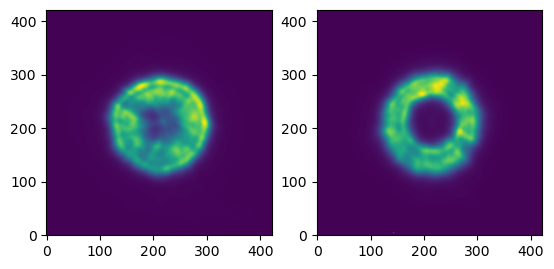

In [24]:
fig,ax = plt.subplots(1,2,)
ax[0].imshow(I1.image, origin='lower')
ax[1].imshow(I2.image, origin='lower')

In [37]:
np.shape(I1.image)

(422, 422)

In [38]:
np.shape(I2.image)

(422, 422)

I don't know what these settings should be in `_run_additional_dz_settings` ... Does it even get used at all ? 

In `ts_wep` we have  for `auxTel` in https://github.com/lsst-ts/ts_wep/pull/159/files#diff-9adb4a6231004344f739856d2949ea2070e4912e51ac1e3337ce250c649157db : 

    self.config.donutStampSize = 200   [px]
    self.config.donutTemplateSize = 200  [px]
    self.config.opticalModel = "onAxis"
    self.config.initialCutoutPadding = 40  [px]
    self.config.instObscuration = 0.3525   [m]
    self.config.instFocalLength = 21.6   [m]
    self.config.instApertureDiameter = 1.2  [m]
    self.config.instDefocalOffset = 32.8   [mm]
    self.config.instPixelSize = 10.0e-6   <- same as below assuming no binning 

Run the `cwfs` algorithm:

In [25]:
# show that the value used for _dz 
# is consistent with `ts_wep` value 
# of offset ... 
offset_m = 32.8*1e-3
dz_m = offset_m / 0.041 
print(dz_m)

_dz =  0.8 # There is  "defocal offset" with a value of 32.8 mm  from https://github.com/lsst-ts/ts_wep/blob/develop/policy/cwfs/instData/auxTel/instParamPipeConfig.yaml
# this value is in the latiss_base_align.py
# if I set _dz = 0.8, then   0.8*0.041  = 32.8 * 1e-3 , i.e. same as in ts_wep config ....
binning = 1  
side = 192 * 1.1  #  https://github.com/lsst-ts/ts_externalscripts/blob/8ba110cd64a134bf7d4efca424477c26deec96eb/tests/auxtel/test_latiss_cwfs_align.py#L525
# from https://github.com/lsst-ts/ts_externalscripts/blob/8ba110cd64a134bf7d4efca424477c26deec96eb/python/lsst/ts/externalscripts/auxtel/latiss_base_align.py#L169

# Create configuration file with the proper parameters
cwfs_config_template = f"""#Auxiliary Telescope parameters:
Obscuration 				0.3525
Focal_length (m)			21.6
Aperture_diameter (m)   		1.2
Offset (m)				{_dz * 0.041}
Pixel_size (m)			{10e-6 *binning}
"""
config_index = "auxtel_latiss"
path = Path(cwfs.__file__).resolve().parents[3].joinpath("data", config_index)
print(path)
if not path.exists():
    os.makedirs(path)
dest = path.joinpath(f"{config_index}.param")
with open(dest, "w") as fp:
    # Write the file and set the offset and pixel size parameters
    fp.write(
        cwfs_config_template
    )

inst = InstrumentCwfs(config_index, int(side * 2 / binning))
algo = AlgorithmCwfs("exp", inst, 1)

0.7999999999999998
/sdf/data/rubin/gpfs/ncsa-home/home/scichris/aos/cwfs/data/auxtel_latiss


In [31]:
# for a slow telescope, should be running in paraxial mode
algo.runIt(inst, I1, I2, "paraxial")


zern = [
    -algo.zer4UpNm[3],  # Coma-X (in detector axes, TBC)
    algo.zer4UpNm[4],  # Coma-Y (in detector axes, TBC)
    algo.zer4UpNm[0],  # defocus
]

Those in the test comments are

    Measured [coma-X, coma-Y, focus] zernike coefficients [nm]:
    [-60.1, 30.8, 50.7, ]
    
    

In [32]:
# with 0.423 obscuration  we get 
# [-59.70118807590336, 30.576862318363638, 50.63583917828914]

# with 0.3525 obscuration we get 
# [-61.218664063026175, 40.716115707831975, 90.19486652163508]
zern  

[-61.218664063026175, 40.716115707831975, 90.19486652163508]

So they are actually very similar! 

# Now run `ts_wep`. Can use the same donut stamps... 


Using the code from [test_latiss_wep_align.py](https://github.com/lsst-ts/ts_externalscripts/blob/develop/tests/auxtel/test_latiss_wep_align.py)

It drives the test - it [instantiates the class](https://github.com/lsst-ts/ts_externalscripts/blob/8ba110cd64a134bf7d4efca424477c26deec96eb/tests/auxtel/test_latiss_wep_align.py#L97)

    self.script = LatissWEPAlign(index=index, remotes=True)
     
     
and then [calls it](https://github.com/lsst-ts/ts_externalscripts/blob/8ba110cd64a134bf7d4efca424477c26deec96eb/tests/auxtel/test_latiss_wep_align.py#L556)
    
    await self.script.run_align()

Using the `LatissWEPAlign` class from [latiss_wep_align.py](https://github.com/lsst-ts/ts_externalscripts/blob/develop/python/lsst/ts/externalscripts/auxtel/latiss_wep_align.py#L194)


The `run_align` calls [runWEP](https://github.com/lsst-ts/ts_externalscripts/blob/8ba110cd64a134bf7d4efca424477c26deec96eb/python/lsst/ts/externalscripts/auxtel/latiss_wep_align.py#L129) , which uses the same procedure as `runCWFS` above: 


--> get the exposures, run ISR

        best_effort_isr = BestEffortIsr()

        exposure_intra = get_image(
            parse_visit_id(intra_visit_id),
            best_effort_isr,
            timeout=timeout_get_image,
        )
        exposure_extra = get_image(
            parse_visit_id(extra_visit_id),
            best_effort_isr,
            timeout=timeout_get_image,
        )

--> perform source measurement 

        quick_frame_measurement_config = QuickFrameMeasurementTask.ConfigClass()
        quick_frame_measurement_task = QuickFrameMeasurementTask(
            config=quick_frame_measurement_config
        )

        result_intra = quick_frame_measurement_task.run(
            exposure_intra, donutDiameter=donut_diameter
        )
        result_extra = quick_frame_measurement_task.run(
            exposure_extra, donutDiameter=donut_diameter
        )

        if not result_intra.success or not result_extra.success:
            raise RuntimeError(
                f"Centroid finding algorithm was unsuccessful. "
                f"Intra image ({exposure_intra}) success is {result_intra.success}. "
                f"Extra image ({exposure_extra}) success is {result_extra.success}."
            )

--> check that brightest sources in intra/extra exposures are in similar locations

        dy = (
            result_extra.brightestObjCentroidCofM[0]
            - result_intra.brightestObjCentroidCofM[0]
        )
        dx = (
            result_extra.brightestObjCentroidCofM[1]
            - result_intra.brightestObjCentroidCofM[1]
        )
        dr = np.sqrt(dy**2 + dx**2)

        position_out_of_range = dr > 100



But then it adds a step of creating donut catalog, since that's passed to `ts_wep`... I can also use the stamps above, and simply run the algorithm by hand, and compare the results...

--> create donut catalog, required by ts_wep

        donut_catalog_intra = get_donut_catalog(result_intra, exposure_intra.getWcs())
        donut_catalog_extra = get_donut_catalog(
            *(
                (result_extra, exposure_extra.getWcs())
                if position_out_of_range
                else (result_intra, exposure_intra.getWcs())
            )
        )

--> instantiate the `ts_wep` measurement  `EstimateZernikesLatissTask` class 

        config = EstimateZernikesLatissTaskConfig()
        config.donutStampSize = donut_diameter
        config.donutTemplateSize = donut_diameter
        config.opticalModel = "onAxis"

        task = EstimateZernikesLatissTask(config=config)

        camera = best_effort_isr.butler.get(
            "camera",
            dataId={"instrument": "LATISS"},
            collections="LATISS/calib/unbounded",
        )

        task_output = task.run(
            [exposure_intra, exposure_extra],
            [donut_catalog_intra, donut_catalog_extra],
            camera,
        )




## 1) use the donut stamps above - run just the algorithm , skipping the `EstimateZernikesLatissTask` 

May be a bit involved.. Basic steps are in `AOS_DM-36840_cocenter_auxTel_data.ipynb`, but since it requires `DonutStamps` class instead of `Image`, would need  to create those from the image array above. 

In [26]:
from lsst.ts.wep.Utility import (
    getConfigDir,
    DonutTemplateType,
    DefocalType,
    CamType,
    getCamType,
    getDefocalDisInMm,
    CentroidFindType
)
from lsst.ts.wep.cwfs.Instrument import Instrument
from lsst.ts.wep.cwfs.Algorithm import Algorithm
from lsst.ts.wep.cwfs.CompensableImage import CompensableImage

instName = 'auxTel'
opticalModel = 'paraxial'#'onAxis'
sizeInPix = 422 # here we make bigger stamps than the usual 200  # donut stamp size 
suffix = 'auxTel'
configDir = getConfigDir()
algoDir = os.path.join(configDir, "cwfs", "algo")
tol=1e-3

# this is part of the init
inst = Instrument()
algo = Algorithm(algoDir)

# inside estimateZernikes()
camType = getCamType(instName)

# inside wfEsti.config
inst.configFromFile(sizeInPix, camType)

# choose the solver for the algorithm
solver = 'exp' # by default
debugLevel = 1 # 1 to 3
algo.config(solver, inst, debugLevel=debugLevel)

centroidFindType = CentroidFindType.RandomWalk
imgIntra = CompensableImage(centroidFindType=centroidFindType)
imgExtra = CompensableImage(centroidFindType=centroidFindType)

# select the only donut pair in that corner
#         donutExtra = donutStampsExtra[i]
#         donutIntra = donutStampsIntra[j]

#         # Inside EstimateZernikesBase
#         # Transpose field XY because CompensableImages below are transposed
#         # so this gets the correct mask orientation in Algorithm.py
#         fieldXYExtra = donutExtra.calcFieldXY()[::-1]
#         fieldXYIntra = donutIntra.calcFieldXY()[::-1]

#         camera = donutExtra.getCamera() # same camera for both donuts
#         detectorExtra = camera.get(donutExtra.detector_name)
#         detectorIntra = camera.get(donutIntra.detector_name)


#         # Rotate any sensors that are not lined up with the focal plane.
#         # Mostly just for the corner wavefront sensors. The negative sign
#         # creates the correct rotation based upon closed loop tests
#         # with R04 and R40 corner sensors.
#         eulerZExtra = -detectorExtra.getOrientation().getYaw().asDegrees()
#         eulerZIntra = -detectorIntra.getOrientation().getYaw().asDegrees()

fieldXYIntra = fieldXY
fieldXYExtra = fieldXYIntra
# now inside  `wfEsti.setImg` method,
# which inherits from `CompensableImage`
imgExtra.setImg(fieldXYExtra,
                DefocalType.Extra,
                image = I2.image)
#                image=rotate(donutExtra.stamp_im.getImage().getArray(), eulerZExtra).T)

imgIntra.setImg(fieldXYIntra,
                DefocalType.Intra,
                image = I1.image)
#               image=rotate(donutIntra.stamp_im.getImage().getArray(), eulerZIntra).T)

boundaryT = algo.getBoundaryThickness()

# right after we set the image, the compensable image mask is empty -
# it is only calculated later in Algorithm
#maskScalingFactorLocal = 1

# algo, store = func.runIt_store(algo, imgIntra, imgExtra, model=opticalModel, 
#                           tol=1e-3,doCoCenter=doCoCenter)

# rename to just like it is in Algorithm.py
algo.runIt(imgIntra, imgExtra, opticalModel, tol=tol)

zer4UpInNm = algo.getZer4UpInNm()



# output from wep are in nm, need to convert to nm.
zern = [
    -zer4UpInNm[4],
    zer4UpInNm[3] ,
   zer4UpInNm[0],
]

In [25]:
zern

[-35.85133393381713, 61.88943759121293, 75.32578593680532]

In [27]:
zern2 = [
    -zer4UpInNm[3],  # Coma-X (in detector axes, TBC)
    zer4UpInNm[4],  # Coma-Y (in detector axes, TBC)
    zer4UpInNm[0],  # defocus
]

In [28]:
zern2

[-61.87371718141303, 35.81710192204437, 75.13666208307237]

So above when running `cwfs`, we got for the same indices `(-zern[3],zern[4],zern[0])`

    [-61.218664063026175, 40.716115707831975, 90.19486652163508]  # obscuration 0.3525, paraxial
    [-59.70118807590336, 30.576862318363638, 50.63583917828914]   # obscuration 0.423, paraxial

whereas here we get 

    -61.88943759121293, 35.85133393381713, 75.32578593680532] # obscuration 0.3525, default in wep 
                                                                (-zern[3],zern[4],zern[0])`,
                                                                onAxis 
    [-61.87371718141303, 35.81710192204437, 75.13666208307237] # wep, 0.3525, paraxial 
    


They are actually VERY close ! 

## 2) Use as a task, providing a `donut_catalog`

Load the postISR exposures, detect sources with `QuickFrameMeasurementTask` : 

In [26]:
# start from postISR data...
from lsst.daf import butler as dafButler
from lsst.pipe.tasks.quickFrameMeasurement import QuickFrameMeasurementTask
qm_config = QuickFrameMeasurementTask.ConfigClass()
qm = QuickFrameMeasurementTask(config=qm_config)

instrument = 'LATISS'
dataId0 = dict(instrument=instrument)
repo_dir = '/sdf/data/rubin/repo/main/'
butler = dafButler.Butler(repo_dir, collections=['run1'])
                      
collection = 'u/scichris/Latiss/testCwfs'

intra_visit_id = 2021110400954
extra_visit_id = 2021110400955
intra_data_id = parse_visit_id(intra_visit_id)
extra_data_id = parse_visit_id(extra_visit_id)


intra_exposure = butler.get(datasetRefOrType='postISRCCD',dataId=intra_data_id,
              collections=[collection])

extra_exposure = butler.get(datasetRefOrType='postISRCCD',dataId=extra_data_id,
              collections=[collection])

side = 192 * 1.1 
intra_result = qm.run(intra_exposure, donutDiameter=2 * side)
extra_result = qm.run(extra_exposure, donutDiameter=2 * side)

INFO:lsst.quickFrameMeasurementTask:Found 29 sources in exposure
INFO:lsst.quickFrameMeasurementTask:Measured 29 of 29 sources in exposure
INFO:lsst.quickFrameMeasurementTask:Found 16 sources in exposure
INFO:lsst.quickFrameMeasurementTask:Measured 16 of 16 sources in exposure


In [27]:
result_intra = intra_result
result_extra = extra_result
exposure_intra = intra_exposure
exposure_extra = extra_exposure

In [28]:
import pandas
from lsst.afw.geom import SkyWcs
from lsst.afw.image import ExposureF
from lsst.pipe.base.struct import Struct
def get_donut_catalog(result: Struct, wcs: SkyWcs) -> pandas.DataFrame:
    """Get the donut catalog, used by wep, from the quick frame measurement
    result.
    Parameters
    ----------
    result : `Struct`
        Result of `QuickFrameMeasurementTask`.
    wcs : `SkyWcs`
        Exposure WCS, to compute Ra/Dec.
    Returns
    -------
    donut_catalog : `pandas.DataFrame`
        Donut catalog.
    """
    ra, dec = wcs.pixelToSkyArray(
        result.brightestObjCentroidCofM[0],
        result.brightestObjCentroidCofM[1],
        degrees=False,
    )

    donut_catalog = pandas.DataFrame([])
    donut_catalog["coord_ra"] = ra
    donut_catalog["coord_dec"] = dec
    donut_catalog["centroid_x"] = [result.brightestObjCentroidCofM[0]]
    donut_catalog["centroid_y"] = [result.brightestObjCentroidCofM[1]]
    donut_catalog["source_flux"] = [result.brightestObjApFlux70]

    donut_catalog = donut_catalog.sort_values(
        "source_flux", ascending=False
    ).reset_index(drop=True)

    return donut_catalog

In [29]:
position_out_of_range = False

In [30]:
donut_catalog_intra = get_donut_catalog(result_intra, exposure_intra.getWcs())
donut_catalog_extra = get_donut_catalog(
    *(
        (result_extra, exposure_extra.getWcs())
        if position_out_of_range
        else (result_intra, exposure_intra.getWcs())
    )
)

In [31]:
donut_catalog_extra

,coord_ra,coord_dec,centroid_x,centroid_y,source_flux
0,1.782142,-0.750966,2708.563751,3098.431083,4.268163e+07


In [32]:
donut_catalog_intra

,coord_ra,coord_dec,centroid_x,centroid_y,source_flux
0,1.782142,-0.750966,2708.563751,3098.431083,4.268163e+07


**NB**: Because of the changes to donut catalog made in `ts_wep` `v4.0.0`, need to revert to `v3.2.0` to make it work:

In [33]:
from lsst.ts.wep.task.EstimateZernikesLatissTask import (
        EstimateZernikesLatissTask,
        EstimateZernikesLatissTaskConfig,
    )

stamp_diameter = int(2 * side) 

config = EstimateZernikesLatissTaskConfig()
config.donutStampSize = stamp_diameter
config.donutTemplateSize = stamp_diameter
config.opticalModel = "onAxis"

task = EstimateZernikesLatissTask(config=config)

camera = butler.get(
    "camera",
    dataId={"instrument": "LATISS"},
    collections="LATISS/calib/unbounded",
)

task_output = task.run(
    [exposure_intra, exposure_extra],
    [donut_catalog_intra, donut_catalog_extra],
    camera,
)

INFO:CombineZernikesSigmaClipTask:Using 1 pairs out of 1 in final Zernike estimate.


In [62]:
task_output.outputZernikesRaw

[array([[ 0.06914695,  0.04616317,  0.12617031,  0.04071832,  0.06852933,
         -0.03318951,  0.0309867 , -0.04036099, -0.01248967,  0.00439077,
          0.01481871,  0.00791797, -0.00401806, -0.00368784,  0.00492969,
          0.00347042, -0.00038205, -0.00685366,  0.01294635]]),
 array([[ 0.06914695,  0.04616317,  0.12617031,  0.04071832,  0.06852933,
         -0.03318951,  0.0309867 , -0.04036099, -0.01248967,  0.00439077,
          0.01481871,  0.00791797, -0.00401806, -0.00368784,  0.00492969,
          0.00347042, -0.00038205, -0.00685366,  0.01294635]])]

In [34]:
task_output.outputZernikesAvg

[array([ 0.06914695,  0.04616317,  0.12617031,  0.04071832,  0.06852933,
        -0.03318951,  0.0309867 , -0.04036099, -0.01248967,  0.00439077,
         0.01481871,  0.00791797, -0.00401806, -0.00368784,  0.00492969,
         0.00347042, -0.00038205, -0.00685366,  0.01294635]),
 array([ 0.06914695,  0.04616317,  0.12617031,  0.04071832,  0.06852933,
        -0.03318951,  0.0309867 , -0.04036099, -0.01248967,  0.00439077,
         0.01481871,  0.00791797, -0.00401806, -0.00368784,  0.00492969,
         0.00347042, -0.00038205, -0.00685366,  0.01294635])]

In [63]:
task_output.outputZernikesAvg[0] - task_output.outputZernikesRaw[0]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.]])

they are identical, since there was only one donut pair to use... 

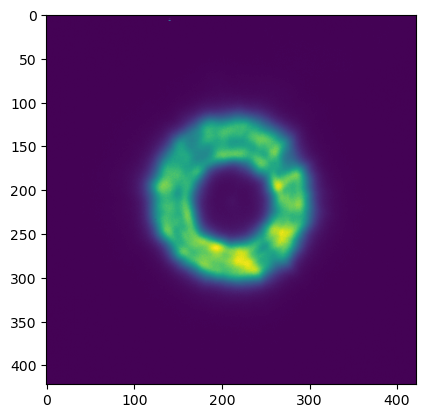

In [58]:
stamp = task_output.donutStampsExtra[0]
plt.imshow(stamp[0].stamp_im.image.array)

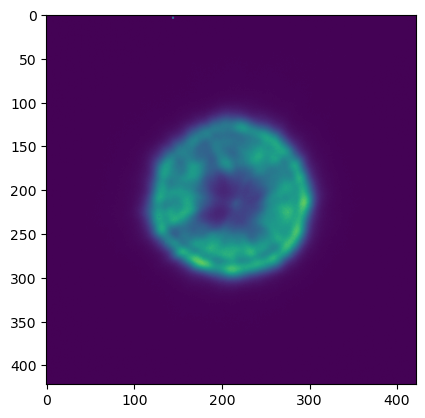

In [61]:
stamp = task_output.donutStampsIntra[0]
plt.imshow(stamp[0].stamp_im.image.array)

In [64]:
zern3 = [
                -task_output.outputZernikesAvg[0][4] * 1e3,
                task_output.outputZernikesAvg[0][3] * 1e3,
                task_output.outputZernikesAvg[0][0] * 1e3,
            ]


In [65]:
zern3

[-68.52932968309277, 40.71831917772295, 69.14695218328815]

In [66]:
zern3a = [
                -task_output.outputZernikesAvg[0][3] * 1e3,
                task_output.outputZernikesAvg[0][4] * 1e3,
                task_output.outputZernikesAvg[0][0] * 1e3,
            ]

In [67]:
zern3a

[-40.71831917772295, 68.52932968309277, 69.14695218328815]

That's different than when running `Algo` directly! I have no idea why, must be the config issue...

So when running `cwfs`, we got for the same indices (-zern[3],zern[4],zern[0])

    [-59.70118807590336, 30.576862318363638, 50.63583917828914]
    
when running `wep` directly we get  (for -zern[3],zern[4],zern[0])

    -61.87371718141303, 35.81710192204437, 75.13666208307237]


when running `wep` as a task we get for these indices -zern[3],zern[4],zern[0]

    [-40.71831917772295, 68.52932968309277, 69.14695218328815]
    
which is quite different! 




Try running the same optical model as for `CWFS` : 

In [17]:

config = EstimateZernikesLatissTaskConfig()
config.donutStampSize = stamp_diameter
config.donutTemplateSize = stamp_diameter
config.opticalModel = "paraxial"

task = EstimateZernikesLatissTask(config=config)

task_output2 = task.run(
    [exposure_intra, exposure_extra],
    [donut_catalog_intra, donut_catalog_extra],
    camera,
)

INFO:CombineZernikesSigmaClipTask:Using 1 pairs out of 1 in final Zernike estimate.


In [23]:
zern4a = [
                -task_output2.outputZernikesAvg[0][3] * 1e3,
                task_output2.outputZernikesAvg[0][4] * 1e3,
                task_output2.outputZernikesAvg[0][0] * 1e3,
            ]

In [24]:
zern3a

[-40.71831917772295, 68.52932968309277, 69.14695218328815]

In [25]:
zern4a

[-40.62700301151789, 68.57103954179267, 69.03660099631787]

So the difference between using `onAxis` and `paraxial` for `ts_wep` is minimal - definitely insufficient to account for the difference between running `CWFS` code vs `ts_wep` code ... 

### 3) Use `CalcZernikes` with `donutTemplate` not used 

Try using `calcZernikes` ... That way 'donutTemplate' is not used - because it is only used in `EstimateZernikesBase` in `cutOutStamps` to convolve the stamp with template and adjust the centroid... https://github.com/lsst-ts/ts_wep/blob/2c244d4e8e627caf235927a5c8cd4dcc2f8a23bd/python/lsst/ts/wep/task/EstimateZernikesBase.py#L435

By the way, the new way would be to use `CutOutDonutsBaseTask` and then `CalcZernikesTask`...

create `donutStamps` from the donut stamp image array... 

In [107]:
result_intra.brightestObjCentroid

(2674.0, 3163.0)

In [114]:
donut_catalog_extra

,coord_ra,coord_dec,centroid_x,centroid_y,source_flux
0,1.782142,-0.750966,2708.563751,3098.431083,4.268163e+07


In [115]:
 exposure_extra.getDetector().getName()

'RXX_S00'

In [120]:
from lsst.ts.wep.task.DonutStamps import DonutStamp, DonutStamps
from lsst.ts.wep.Utility import (
    getCamTypeFromButlerName,
    createInstDictFromConfig,
)
import lsst.afw.cameraGeom
instParams = createInstDictFromConfig(config)

detectorName = exposure_intra.getDetector().getName()
cameraName = "LATISS"
offset = 32.8 # mm
# Save MaskedImage to stamp
stamps_intra = []
stamps_intra.append(
                DonutStamp(
                    stamp_im=I1.image,
                    sky_position=lsst.geom.SpherePoint(
                        0,
                        0,
                        lsst.geom.radians,),
                    centroid_position=lsst.geom.Point2D(result_intra.brightestObjCentroid),
                    detector_name=detectorName,
                    cam_name=cameraName,
                    defocal_type=DefocalType.Intra,
                    # Save defocal offset in mm.
                    defocal_distance=offset,
                )
            )

catalogLength = len(donut_catalog_intra)
    
stampsMetadata = PropertyList()
stampsMetadata["RA_DEG"] = np.degrees(donut_catalog_intra["coord_ra"].values)
stampsMetadata["DEC_DEG"] = np.degrees(donut_catalog_intra["coord_dec"].values)
stampsMetadata["DET_NAME"] = np.array([detectorName] * catalogLength, dtype=str)
stampsMetadata["CAM_NAME"] = np.array([cameraName] * catalogLength, dtype=str)
stampsMetadata["DFC_TYPE"] = np.array([DefocalType.Intra * catalogLength])
stampsMetadata["DFC_DIST"] = np.array(
            [offset] * catalogLength
        )
# Save the centroid values
stampsMetadata["CENT_X"] = np.array(donut_catalog_intra["centroid_x"])
stampsMetadata["CENT_Y"] = np.array(donut_catalog_intra["centroid_y"])


intra_stamps = DonutStamps(stamps_intra, metadata=stampsMetadata)

AttributeError: 'numpy.ndarray' object has no attribute 'getImage'

I can't figure out how to make DonutStamps from that by hand ... If I could get the donut stamps to be made by hand, then I'd do next : 

In [ ]:
from lsst.ts.wep.task.CalcZernikesTask import (
    CalcZernikesTask,
    CalcZernikesTaskConfig,
)
config = CalcZernikesTaskConfig(opticalModel='onAxis')
task = CalcZernikesTask(config=config, name="Base Task")
zernCoeff = task.run(donutStampsExtra, donutStampsIntra)